<a href="https://colab.research.google.com/github/widifadi/ndvi_calculation-python/blob/main/NDVI_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Only run this block on google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install rasterio matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 56.6 MB/s eta 0:00:00


#### Load Images and Bands

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# File paths
sr_image_path = '../../Sample_data_-Braga_psscene_analytic_sr_udm2/PSScene/20250427_033924_57_24dc_3B_AnalyticMS_SR_clip.tif'
udm2_path = '../../Sample_data_-Braga_psscene_analytic_sr_udm2/PSScene/20250427_033924_57_24dc_3B_udm2_clip.tif'

# Load SR image
with rasterio.open(sr_image_path) as src:
    blue = src.read(1).astype('float32')   # Band 1: Blue
    green = src.read(2).astype('float32')  # Band 2: Green
    red = src.read(3).astype('float32')    # Band 3: Red
    nir = src.read(4).astype('float32')    # Band 4: NIR
    profile = src.profile

# Apply scale factor
scale = 0.0001
blue *= scale
green *= scale
red *= scale
nir *= scale

#### NDVI Calculation

In [2]:
np.seterr(divide='ignore', invalid='ignore')
ndvi = (nir - red) / (nir + red)

#### Apply Cloud Masking

In [3]:
# Load UDM2 cloud mask (band 6: cloud confidence)
with rasterio.open(udm2_path) as udm2_src:
    cloud_mask = udm2_src.read(6).astype('uint8')

# Mask where cloud_mask == 1
mask = cloud_mask == 1
ndvi_masked = np.where(mask, np.nan, ndvi)

#### Plotting All three results

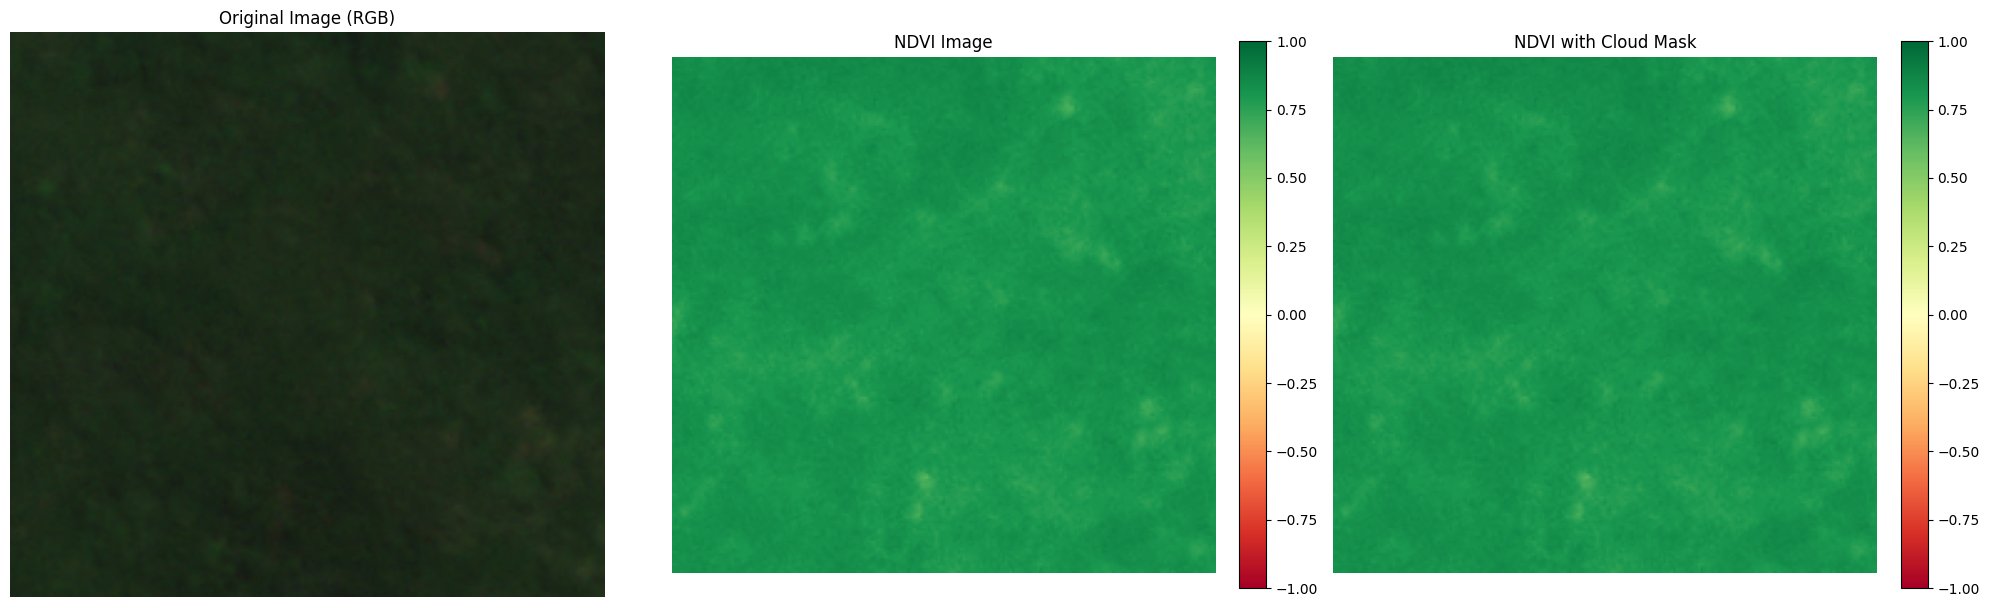

In [4]:
# RGB composite for visualization (simple stretch)
rgb = np.stack([red, green, blue], axis=-1)
rgb = np.clip(rgb / 0.3, 0, 1)  # Normalize for display

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(20, 7))

# Original RGB
axs[0].imshow(rgb)
axs[0].set_title("Original Image (RGB)")
axs[0].axis('off')

# NDVI
im1 = axs[1].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
axs[1].set_title("NDVI Image")
axs[1].axis('off')
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# NDVI with cloud mask
im2 = axs[2].imshow(ndvi_masked, cmap='RdYlGn', vmin=-1, vmax=1)
axs[2].set_title("NDVI with Cloud Mask")
axs[2].axis('off')
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

#### Save the outputs

In [6]:
import os
from rasterio.enums import Resampling

# Output directory
output_dir = './outputs'
os.makedirs(output_dir, exist_ok=True)

# Save NDVI image
ndvi_output_path = os.path.join(output_dir, 'ndvi.tif')
profile.update(dtype=rasterio.float32, count=1)
with rasterio.open(ndvi_output_path, 'w', **profile) as dst:
    dst.write(ndvi.astype(np.float32), 1)

# Save NDVI with mask
ndvi_masked_output_path = os.path.join(output_dir, 'ndvi_masked.tif')
with rasterio.open(ndvi_masked_output_path, 'w', **profile) as dst:
    dst.write(ndvi_masked.astype(np.float32), 1)

# Save RGB composite (optional)
rgb_output_path = os.path.join(output_dir, 'rgb_visual.tif')
rgb_profile = profile.copy()
rgb_profile.update(dtype=rasterio.float32, count=3)

with rasterio.open(rgb_output_path, 'w', **rgb_profile) as dst:
    dst.write(red.astype(np.float32), 1)
    dst.write(green.astype(np.float32), 2)
    dst.write(blue.astype(np.float32), 3)

print("Saved:")
print(" - NDVI:", ndvi_output_path)
print(" - NDVI Masked:", ndvi_masked_output_path)
print(" - RGB Visual:", rgb_output_path)

Saved:
 - NDVI: ./outputs\ndvi.tif
 - NDVI Masked: ./outputs\ndvi_masked.tif
 - RGB Visual: ./outputs\rgb_visual.tif
